### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Datenanalyse -
<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der Amazon Daten</ul>
    <ul>
     <ul>3.1. Entpacken der Zip Files</ul>
     <ul>3.2. Laden des Datensatzes in einen Data Frame</ul>
    </ul>
<ul>4. Analyse der Review Daten</ul>
    <ul>
     <ul>4.1. Allgemeiner Überblick</ul>
     <ul>4.2. Analyse einzelner Spalten</ul>
        <ul>
         <ul>4.2.1. reviewText</ul>
         <ul>4.2.2. unixReviewTime</ul>
         <ul>4.2.3. overall</ul>
         <ul>4.2.4. asin</ul>
        </ul>
    </ul>
<ul>5. Analyse der Meta Daten</ul>
    <ul>
     <ul>5.1. Allgemeiner Überblick</ul>
     <ul>5.2. Analyse einzelner Spalten</ul>
        <ul>
         <ul>5.2.1. title</ul>
         <ul>5.2.2. brand</ul>
        </ul>
    </ul>
<ul>6. Literaturverzeichnis</ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Datenanalyse der Amazon Daten und dient als Vorbereitung für die spätere Data Preperation, Implementierung und Evaluierung der Topic Modelling Modelle.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter dem Kapitel "4.2. Explorative Datenanalyse" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [1]:
# Instalationen
% pip install gzip
% pip install shutil
% pip install nltk
%pip install LanguageIdentifier

### 2.2. Imports

In [1]:
# Allgemeine Imports
import datetime
import random
import numpy as np
import pandas as pd
from pandas import json_normalize

# Progressbar
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Entpacken der Files
import gzip
import shutil

# Beschleunigung
import json
import joblib
from joblib import Parallel, delayed

# Analyse
from LanguageIdentifier import predict

# Datenvisualisierung
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import plotly.express as px
import plotly.io as pio
pio.renderers
from plotly.offline import plot, iplot, init_notebook_mode
#import plotly.graph_objs as go
init_notebook_mode(connected=True)
#import dash
from dash import dcc
#import dash_core_components as dcc 
from jupyter_dash import JupyterDash
from dash import html    
#import dash_html_components as html
from dash.dependencies import Input, Output

C:\Users\nuiss\AppData\Local\Temp\ipykernel_21884\1929997563.py:39: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



## 3. Laden der Amazon Daten

### 3.1. Entzippen der Json Files
Die Amazon Datensätze sind aufgrund der großen Datenmengen als Zip Dateien gespeichert. Um diese in das Jupyter Notebook einlesen zu können, müssen daher die JSON Files zuerst entpackt werden.

Zum Entpacken der Files wird im Folgenden "gzip" in Verbindung mit "shutil" verwendet. 
Gzip ist ein Programm zur Daten Kompression (Free Software Foundation, 2022) während shutil ein Modul ist, welches diverse High-Level-Operationen zur Unterstützung beim Kopieren und Löschen von Dateien bietet (Python-Software-Foundation, 2023). 
Durch deren Kombination werden zuerst zwei Files geöffnet. file_in beschreibt hier das gezippte JSON file und bei file_out handelt es sich um ein leeres JSON File, in welches die Daten aus file_in mithilfe der Funktion "copyfileobj" von shutil kopiert werden (Erick, 2018). 

In [3]:
# Entpacken der Datei und speichern in einem JSON File
# Quelle: https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python
# Review Daten
with gzip.open('Sports_and_Outdoors_5.json.gz', 'rb') as file_in:
    with open('Sports_and_Outdoors_5.json', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)

# Meta Daten
with gzip.open('meta_Sports_and_Outdoors.json.gz', 'rb') as file_in:
    with open('meta_Sports_and_Outdoors.json', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)

### 3.2. Laden des Datensatzes in einen Data Frame

Nachdem die Datensätze entpackt wurden, können diese geladen in einen Data Frame gespeichert werden. Aufgrund der großen Datenmenge wird joblib zur Beschleunigung herangezogen.

In [2]:
# Review Daten
# Öffnen der Datei und speichern als Objekt in der Variable f
r = open('Sports_and_Outdoors_5.json')

# Laden des JSON Files in das Jupyter Notebook mit Beschleunigung
dataset_review = Parallel(n_jobs=-1)(delayed(json.loads)(line) for line in tqdm(r, desc ="Status der geladenen Zeilen: ", total = 2839940))

# Normalisieren der Daten und Laden in einen Data Frame
review_df = json_normalize(dataset_review)

Status der geladenen Zeilen:   0%|          | 0/2839940 [00:00<?, ?it/s]

In [3]:
# Meta Daten
# Öffnen der Datei und speichern als Objekt in der Variable f
m = open('meta_Sports_and_Outdoors.json')

# Laden des JSON Files in das Jupyter Notebook mit Beschleunigung
dataset_meta = Parallel(n_jobs=-1)(delayed(json.loads)(line) for line in tqdm(m, desc ="Status der geladenen Zeilen: ", total = 962300))

# Normalisieren der Daten und Laden in einen Data Frame
meta_df = json_normalize(dataset_meta)

Status der geladenen Zeilen:   0%|          | 0/962300 [00:00<?, ?it/s]

## 4. Analyse der Review Daten

Im Folgendem werden die Daten des "Review Datensatzes" genauer untersucht. Im Rahmen dieser Masterarbeit wurde aus Performancegründen Bezug auf den Datensatz „Sports_and_Outdoors_5“ genommen, welcher eine repräsentative, gekürtzte Version des "Sports and Outdoors" Datensatzes von Amazon darstellt (Free Software Foundation, 2022).

### 4.1. Allgemeiner Überblick

Zu Beginn wird ein erster grober Überblick über die Datenstrukturen des Datensatzes gegeben.

#### __Anzahl der Zeilen und Spalten__

In [6]:
# Anzahl der Zeilen und Spalten
row_r = len(review_df)
column_r = len(review_df.columns)

# Ausgabe
print(f"Der Review Datensatz enthält {row_r} Zeilen und {column_r} Spalten")

Der Review Datensatz enthält 2839940 Zeilen und 55 Spalten


#### __Spalten und deren Datantypen__

In [7]:
# Keys und Datentypen der Spalten
print("Das Dicitionary zu dem Review Dataset beinhaltet folgende Keys: ")
for key in dataset_review[0].keys():
    print(f"key: {key}, datentyp des keys: {type(dataset_review[0][key])}") 

Das Dicitionary zu dem Review Dataset beinhaltet folgende Keys: 
key: overall, datentyp des keys: <class 'float'>
key: verified, datentyp des keys: <class 'bool'>
key: reviewTime, datentyp des keys: <class 'str'>
key: reviewerID, datentyp des keys: <class 'str'>
key: asin, datentyp des keys: <class 'str'>
key: reviewerName, datentyp des keys: <class 'str'>
key: reviewText, datentyp des keys: <class 'str'>
key: summary, datentyp des keys: <class 'str'>
key: unixReviewTime, datentyp des keys: <class 'int'>


In [8]:
# Spalten des DataFrames (nach Normalisierung)
print("Der Data Frame zu dem Reiview Dataset beinhaltet folgende Spalten: ")
review_df.columns

Der Data Frame zu dem Reiview Dataset beinhaltet folgende Spalten: 


Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'style.Format:', 'vote', 'style.Color:', 'image', 'style.Size:',
       'style.Style Name:', 'style.Team Name:', 'style.Style:',
       'style.Package Quantity:', 'style.Size Name:',
       'style.Product Packaging:', 'style.Package Type:',
       'style.Model Number:', 'style.Hand Orientation:', 'style.Color Name:',
       'style.Item Shape:', 'style.Shape:', 'style.Flavor:', 'style.Platform:',
       'style.Line Weight:', 'style.Item Display Weight:',
       'style.Item Package Quantity:', 'style.Flex:', 'style.Loft:',
       'style.Material:', 'style.Shaft Material:', 'style.Tension Supported:',
       'style.Pattern:', 'style.Design:', 'style.Flavor Name:',
       'style.Item Display Length:', 'style.Length:', 'style.Number of Items:',
       'style.Material Type:', 'style.Department:', 'style.Edition:',
       'style.Configuration:', 'style.Wid

#### __Nan-Values__

In [4]:
# Fehlende Werte im Data Frame (Reviews)
nan_df = review_df.isna().sum().to_frame('nulls')
nan_df.reset_index(inplace=True)

# Graphische Ausgabe
nan_fig = px.bar(nan_df, x="index", y="nulls", title="Nan - Values pro Spalte", text_auto='.2s',
                 color_discrete_sequence=px.colors.sequential.Darkmint_r)
#nan_fig.show(renderer="svg")

In [5]:
nan_fig

### 4.2. Analyse einzelner Spalten

Im folgenden Abschnitt werden einzelne Spalten des Data Frames eingehender unterschucht, um deren Inhalte besser zu verstehen und den Datensatz ggf. vorselektieren zu können.

Hierfür werden dem Data Frame jedoch zuerst alle Spalten entnommen, welche eine zu hohe Anzahl an Nan - Values enthalten (Erkennbar in obenstehender Graphik). Darüber hinaus werden die Spalten "reviewerID" und "reviewerName" herausgenommen, da im Rahmen der Masterarbeit kein Bezug zu den Usern hergestellt werden soll. Auch die Spalte "verified" liefert für die Analyse der Produktreviews keine relevanten Informationen und muss nicht weiter berücksichtigt werden. Des Weiteren werden an dieser Stelle die Nan - Values der Spalte "reviewText" gedroppt, sowie Dublikate entfernt. Somit ergibt sich folgender neuer Data Frame für die weitere Analyse:

In [10]:
# Erstellen eines neuen DataFrames mit den relevanten Spalten
review_df = review_df[["reviewText", "asin", "overall", "unixReviewTime"]]

# Droppen der Nan - Values der reviewTexte
review_df= review_df.dropna(subset=['reviewText'])
review_df.reset_index(inplace=True, drop=False)
review_df= review_df.drop("index", axis=1)

# Entfernung von Dublikaten
review_df.drop_duplicates(inplace=True)
review_df.reset_index(inplace=True, drop=False)
review_df= review_df.drop("index", axis=1)

# Ausgabe
review_df

,reviewText,asin,overall,unixReviewTime
0,What a spectacular tutu! Very slimming.,0000032034,5.0,1433289600
1,What the heck? Is this a tutu for nuns? I know...,0000032034,1.0,1427846400
2,Exactly what we were looking for!,0000032034,5.0,1421107200
3,I used this skirt for a Halloween costume and ...,0000032034,5.0,1419292800
4,This is thick enough that you can't see throug...,0000032034,4.0,1418601600
...,...,...,...,...
2688110,"Love the shorts.. amazing comfortable, perfect...",B01HJGAJ9O,5.0,1522886400
2688111,Superb quality,B01HJGAJ9O,5.0,1519862400
2688112,Works every time,B01HJHHBHG,5.0,1521244800
2688113,I have a briley bolt release paddle installed ...,B01HJHHBHG,5.0,1509148800


### 4.2.1. reviewText

Der "reviewText" bildet die Grundlage für die Topic Modelling Modelle und ist daher essenziell. Die Wordcloud gibt einen ersten groben Eindruck über den Inhalt der Reviews. Des Weiteren werden in diesem Anschnitt die Sprache der verfassten Texte, sowie deren Länge unteruscht.

(-0.5, 1659.5, 951.5, -0.5)

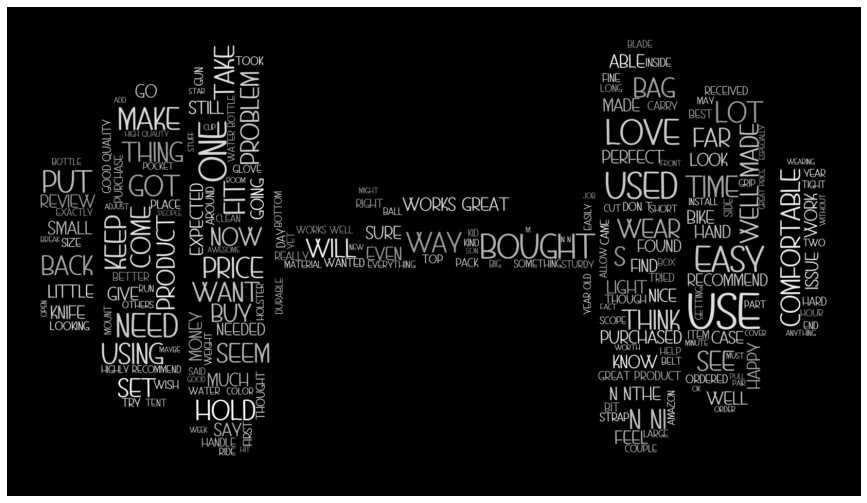

In [40]:
# Erstellung einer Wordcloud als erster Überblick über die Review Daten
# Quelle: https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
# Transformation der Spalte "reviewText" zu einem String
text = review_df['reviewText'].values.tolist()
text = str(text)

# Generierung des Images der Wordcloud
mask_sport = np.array(Image.open("image_sport.jpeg"))
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Generierung der Wordcloud
wordcloud = WordCloud(mask=mask_sport, background_color="black", font_path='Thinkpad.otf', width=875, height=620, collocations=True).generate(text)
plt.figure(figsize=[16, 9])
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")

# Speichern der Wordcloud
#plt.savefig("wordcloud.png", format="png")

#### __Sprache__

Zur Vereinfachnung sollen für die Topic Modelling Algorithmen lediglich englischsprachige Reviewtexte herangezogen werdne. Aus perfomance Gründen wird für die Analyse der Sprache eine Stichprobe des Datensatzes herangezogen. Auf diesen Weg kann herausgefunden werden, ob der Datensatz lediglich englischsprachige Texte enthält. Ist dies nicht der Fall müssten die anderssprachigen Reviews entweder übersetzt oder dem Datensatz entnommen werden.

In [14]:
# Funktion zur Ermittlung der Sprache
# Quelle: https://pypi.org/project/LanguageIdentifier/
def identifier(in_string):
    language = predict(in_string)
    return language

In [15]:
# Erzeugen einer Stichprobe
sample_df = review_df.sample(frac=0.05)

# Ausgabe
print(f"Der Beispieldatensatzt enhält {len(sample_df)} Zeilen. Dies entspricht 5% des gesammten Datensatzes")

Der Beispieldatensatzt enhält 134406 Zeilen. Dies entspricht 5% des gesammten Datensatzes


In [16]:
# Definition der Funktion zur Analyse der Sprache
def identifier(in_string):
    language = predict(in_string)
    return language

In [17]:
# Anwenden der Funktion auf die Stichprobe des Datensatzes
sample_df["language"] = Parallel(n_jobs=-1)(delayed(identifier)(in_string) for in_string in tqdm(sample_df["reviewText"], 
                                                                                                desc ="Status ermittelten Sprache pro Dokument: ",
                                                                                                total = len(sample_df["reviewText"])))

Status ermittelten Sprache pro Dokument:   0%|          | 0/134406 [00:00<?, ?it/s]

c:\Users\nuiss\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [18]:
# Gruppieren und Zählen der Sprachen in den Review Texten
languages_df = sample_df.groupby(["language"]).size().reset_index(name="count")

# Ausgabe
language_fig = px.bar(languages_df, x="language", y="count", title="Sprache der Review Texte: Sports and Outdoors", text_auto='.2s',
                      color_discrete_sequence=px.colors.sequential.Darkmint_r)
language_fig

In [19]:
# Ermittlung des Anteils nicht-englischsprachiger Reviews
not_english_df = sample_df[(sample_df["language"] != "en")]
not_english_sample = round(len(not_english_df)/len(sample_df) * 100, 2)
not_englisch_all = round(len(review_df) * not_english_sample / 100,)

# Ausgabe
print(f"Der Beispieldatensatzt enhält {len(not_english_df)} Zeilen, welche nicht in englischer Sprache sind. Dies entspricht {not_english_sample} des gesammten Beispieldatensatzes.")
print(f"Somit könnte der gesammte Datensatz hochgerechnet etwa {not_englisch_all} Zeilen enthalten, welche nicht englischsprachig sind.")
print("Jedoch sind nicht alle Sprachen fehlerfrei identifiziert worden: ")
not_english_df.head(10)

Der Beispieldatensatzt enhält 1925 Zeilen, welche nicht in englischer Sprache sind. Dies entspricht 1.43 des gesammten Beispieldatensatzes.
Somit könnte der gesammte Datensatz hochgerechnet etwa 38440 Zeilen enthalten, welche nicht englischsprachig sind.
Jedoch sind nicht alle Sprachen fehlerfrei identifiziert worden: 


,reviewText,asin,overall,unixReviewTime,language
1138100,Works,B007595CZW,5.0,1412380800,de
939852,EXCELLENT,B004U9KIUE,5.0,1432512000,de
2463916,Happy,B004ZIEWIY,5.0,1491696000,fi
1746701,no problem,B00MC59BA6,5.0,1456704000,ca
1517275,ok,B00FORA51S,3.0,1466467200,hu
1909737,USA!,B00TBKAIRA,5.0,1474588800,et
1708486,Kinda small,B00L3LVA4K,4.0,1495411200,et
1564692,A ok,B00H07DBX4,5.0,1480636800,hu
379626,. . .,B00136X6VU,4.0,1504742400,cs
1717727,Cheap. Zipper,B00LEYAPEW,1.0,1425600000,de


#### __Länge der Texte__

Je länger ein verfasster Review Text ist , desto aufschlussreicher kann dieser evtl. für die Entscheidungsunterstüzung beispielsweise bei der Verbesserung von Produkten sein. Besteht ein Review lediglich aus den Worten "Love it", "Excelent" oder "Disaster", so lässt sich zwar ein Stimmungsbild einfangen, jedoch sind keine relevanten Informationen enthalten, welche eine Verbesserung des Produtes oder des Services herbeiführen könnten. Aus diesem Grund werden im Folgenden die Zeichenlängen der Reviews ermittelt, um ggf. in der Data Preperation den Datensatz um zu kurze Reviews zu verringern.

In [20]:
# Funktion zur bestimmung der Länge der Texte pro "Dokument" / Zeile
def count_text_len(in_string):
    text_len = len(in_string.split())
    return text_len

In [21]:
# Anwendung der Funktion zur Ermittlung der Länge (Wörter) der Reviews
review_df["text_len"] = Parallel(n_jobs=-1)(delayed(count_text_len)(in_string) for in_string in tqdm(review_df["reviewText"], 
                                                                                                desc ="Status der Ermittlung der Länge der Dokumente: ",
                                                                                                total = len(review_df["reviewText"])))

Status der Ermittlung der Länge der Dokumente:   0%|          | 0/2688115 [00:00<?, ?it/s]

c:\Users\nuiss\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [22]:
# Gruppieren und Zählen der Längen der Review Texten
text_len_df = review_df.groupby(["text_len"]).size().reset_index(name="count")

# Konvertierung der Spalte mit den Längenangaben in int
text_len_df["text_len"] = text_len_df["text_len"].astype(int)

# Aufsteigende Sortierung der Länge
text_len_df = text_len_df.sort_values(by=['text_len'])

# Graphische Darstellung
print(f"Der Datensatz könnte um {len(review_df[(review_df.text_len <= 4)])} Zeilen reduziert werden, falls alle Reviews mit weniger als 5 Zeichen herausgenommen werden.")
text_len_fig = px.line(text_len_df, x="text_len", y="count", log_x=True, title="Länge der Review Texte: Sports and Outdoors",
                       color_discrete_sequence=px.colors.sequential.Darkmint_r)
text_len_fig.update_xaxes(title_text= "Länge der Review Texte (in Zeichen)")
text_len_fig.update_yaxes(title_text= "Anzahl der Reviews")
text_len_fig


Der Datensatz könnte um 397476 Zeilen reduziert werden, falls alle Reviews mit weniger als 5 Zeichen herausgenommen werden.


### 4.2.2. unixReviewTime

Um einen Rückschluss auf die Veränderungen der Reviews über die Jahre hinweg ziehen zu können, wird die Spalte "unixReviewTime" herangezogen.

Dieses Zeitformat ermöglicht es die Zeit als fortlaufende Summe von Sekunden anzuzeigen und wird auch als Unix-Epoche bezeichnet. Die erste Epoche begann am 01.01.1970 um UTC. Der Zeitstempel zeigt folglich die Sekunden von diesem Zeitpunkt bis zum gewünschten Zeitpunkt an. (DansTools.com, 2014). Für eine Weiterverarbeitung wird dieses Format in ein Datetime Format konvertiert.

In [23]:
# Umrechnung der unixReviewTime in einen Timestamp
# Quelle: https://www.adamsmith.haus/python/answers/how-to-convert-a-column-of-unix-times-in-a-pandas-dataframe-to-datetimes-in-python
review_df["unixReviewTime"] = pd.to_datetime(review_df["unixReviewTime"], unit='s')

# Aufsplitten in Jahre und Monate
review_df['year'] = pd.DatetimeIndex(review_df["unixReviewTime"]).year

# Gruppieren und Zählen der Jahre in welchen die Bewertungen geschrieben wurden
date_df = review_df.groupby(["year"]).size().reset_index(name="count")

# Graphische Darstellung
date_fig = px.bar(date_df, x="year", y="count", title="Häufigkeit der Reviews über die Jaher hinweg: Sports and Outdoors",
                  color_discrete_sequence=px.colors.sequential.Darkmint_r)
date_fig.update_xaxes(title_text= "Jahre")
date_fig.update_yaxes(title_text= "Anzahl der Reviews")
date_fig

### 4.2.3. overall

Die Spalte "overall" gibt eine Sternebewertung für das Produkt an. Die Produkte können von einem bis fünf bewertet werden. Die Abbildung zeigt die Häufigkeiten, mit welchen die Produkte die jeweiligen Sterne erhalten haben.

In [24]:
# Gruppieren und Zählen der Sterne-Bewertungen
stars_df = review_df.groupby(["overall"]).size().reset_index(name="count")

# Ausgabe
stars_fig = px.pie(stars_df, values="count", names="overall", title="Sternebewertungen der Review Texte: Sports and Outdoors",
                   color_discrete_sequence=px.colors.sequential.Darkmint_r)
stars_fig

### 4.2.4. asin

In der Spalte „asin“ ist die Nummer des Produktes angegeben, welches in dem Review bewertet wurde. Diese kann dazu verwendet werden, um die Review Daten um zusätzlichen Informationen der Meta Daten zu erweitern und die Bewertungen in Verbindung mit den Produkten zu setzen.

In [25]:
# Gruppieren und Zählen der Bewertungen für die jeweiligen Produkte
product_df = review_df.groupby(["asin"]).size().reset_index(name="count")

# Ausgabe
print(f"Es wurden insgesammt {len(product_df)} Produkte bewertet")

Es wurden insgesammt 104687 Produkte bewertet


## 5. Analyse der Meta Daten

Der Meta Datensatz enthält diverse wichtige Informationen zu den Produkte, welche im Review Datensatz bewertet wurden. Im folgenden wird ebenfalls ein kurzer Überblick über die Datenstrukturen des Datensatzes gegeben. Daraufhin werden die Meta Daten in Verbindung zu dem Review Datensatz gesetzt und näher untersucht.

### 5.1. Allgemeiner Überblick

#### __Anzahl der Zeilen und Spalten__

In [26]:
# Anzahl der Zeilen
row_m = len(meta_df)
column_m = len(meta_df.columns)

# Ausgabe
print(f"Der Meta Datensatz enthält {row_m} Zeilen (Produkte) und {column_m} Spalten")

Der Meta Datensatz enthält 962300 Zeilen (Produkte) und 53 Spalten


#### __Spalten und deren Datentypen__

In [27]:
# Keys und Datentypen der Spalten
print("Das Dicitionary zu dem Meta Dataset beinhaltet folgende Keys: ")
for key in dataset_meta[0].keys():
    print(f"key: {key}, datentyp des keys: {type(dataset_meta[0][key])}") 

Das Dicitionary zu dem Meta Dataset beinhaltet folgende Keys: 
key: category, datentyp des keys: <class 'list'>
key: tech1, datentyp des keys: <class 'str'>
key: description, datentyp des keys: <class 'list'>
key: fit, datentyp des keys: <class 'str'>
key: title, datentyp des keys: <class 'str'>
key: also_buy, datentyp des keys: <class 'list'>
key: tech2, datentyp des keys: <class 'str'>
key: brand, datentyp des keys: <class 'str'>
key: feature, datentyp des keys: <class 'list'>
key: rank, datentyp des keys: <class 'str'>
key: also_view, datentyp des keys: <class 'list'>
key: main_cat, datentyp des keys: <class 'str'>
key: similar_item, datentyp des keys: <class 'str'>
key: date, datentyp des keys: <class 'str'>
key: price, datentyp des keys: <class 'str'>
key: asin, datentyp des keys: <class 'str'>
key: imageURL, datentyp des keys: <class 'list'>
key: imageURLHighRes, datentyp des keys: <class 'list'>


In [28]:
# Spalten des DataFrames (nach Normalisierung)
print("Der Data Frame zu dem Reiview Dataset beinhaltet folgende Spalten: ")
meta_df.columns

Der Data Frame zu dem Reiview Dataset beinhaltet folgende Spalten: 


Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes',
       'details.Shipping Weight:', 'details.ASIN: ',
       'details.Item model number:',
       'details.\n    Product Dimensions: \n    ',
       'details.Domestic Shipping: ', 'details.International Shipping: ',
       'details.Shipping Advisory:', 'details.Hardcover:',
       'details.Publisher:', 'details.ISBN-10:', 'details.ISBN-13:',
       'details.\n    Package Dimensions: \n    ',
       'details.\n    Item Weight: \n    ', 'details.Batteries',
       'details.Audio CD', 'details.Number of Discs:', 'details.Label:',
       'details.ASIN:', 'details.Original Release Date:', 'details.Run Time:',
       'details.Audio Cassette', 'details.Discontinued by manufacturer:',
       'details.UPC:', 'details.SPARS Code:', 'details.Language:',
       'details. Date first l

#### __NaN Values__

In [29]:
# Fehlende Werte im Data Frame (Meta Daten)
nan_df = meta_df.isna().sum().to_frame('nulls')
nan_df.reset_index(inplace=True)

# Graphische Ausgabe
nan_fig = px.bar(nan_df, x="index", y="nulls", title="Nan - Values pro Spalte", text_auto='.2s',
                 color_discrete_sequence=px.colors.sequential.Darkmint_r)
nan_fig

### 4.2. Analyse einzelner Spalten

Im folgenden wird der Review Datensatz um die Spalten "title", "brand" und "price" aus dem Meta Datensatz ergänzt indem diese über die Spalte "asin" gemerged werden. Da diese vorselektierten Spalten keinen Nan Values beinhalten ist hierbei ein löschen dieser Werte nicht nötig. 

In [30]:
# Erstellen eines neuen DataFrames mit den relevanten Spalten
meta_df = meta_df[["asin", "title", "brand", "price"]]

# Merge der Meta Daten mit dem bereinigeten Datensatz
merged_df = review_df.merge(meta_df, on="asin", how='left')

# Ausgabe
merged_df.head(5)

,reviewText,asin,overall,unixReviewTime,text_len,year,title,brand,price
0,What a spectacular tutu! Very slimming.,0000032034,5.0,2015-06-03,6,2015,Adult Ballet Tutu Yellow,BubuBibi,$12.50
1,What the heck? Is this a tutu for nuns? I know...,0000032034,1.0,2015-04-01,39,2015,Adult Ballet Tutu Yellow,BubuBibi,$12.50
2,Exactly what we were looking for!,0000032034,5.0,2015-01-13,6,2015,Adult Ballet Tutu Yellow,BubuBibi,$12.50
3,I used this skirt for a Halloween costume and ...,0000032034,5.0,2014-12-23,84,2014,Adult Ballet Tutu Yellow,BubuBibi,$12.50
4,This is thick enough that you can't see throug...,0000032034,4.0,2014-12-15,28,2014,Adult Ballet Tutu Yellow,BubuBibi,$12.50


### 5.2.1. title

Jede Produktnummer ("asin") hat einen Titel um näher zu spezifizieren um was es sich handelt. Hierbei ist es interressant zu analysieren, wie viele Produkte aus dem Metadatensatz überhaubt bewertet wurden. Des Weiteren ist zu untersuchen, welche Produkte durch eine hohe Anzahl an Reviews ein repräsentatives Stimmungs- und Meinungsbild der Nutzer abgeben und über welchen Produkten aufgrund mangelnder Reviews keine Informationen gewonnen werden können.

In [31]:
# Anzahl der bewerteten Produkte
print(f"Es wurden insgesammt {len(merged_df.asin.unique())} verschiedene Produkte bewertet.")

Es wurden insgesammt 104687 verschiedene Produkte bewertet.


#### __Top 10 der am Häufigsten bewerteten Produkten__

Manche Produkte erhalten mehr Reviews als andere. Hier sind die Top 10 Produkte aufgeführt, welche die meisten Bewertungen durch die Nutzer erhalten haben.

In [32]:
# Gruppieren und Zählen der Sterne-Bewertungen
title_df = merged_df.groupby(["title"]).size().reset_index(name="count")

# Aufsteigende Sortierung der Anzahl der Sterne-Bewertungen
title_df = title_df.sort_values(by=['count'], ascending=False)
title_df.reset_index(inplace=True, drop=False)
title_df= title_df.drop("index", axis=1) 

# Auswählen der Top 10 Produkte
top_10_df = title_df.iloc[:10]

# Ausgabe
print("Die Top 10 am häufigsten bewerteten Produkte sind: ")
top_10_df

Die Top 10 am häufigsten bewerteten Produkte sind: 


,title,count
0,UGG Men's Ascot Slipper,11545
1,Speedo Vanquisher 2.0 Mirrored Swim Goggle,6334
2,Hanes Adult EcoSmart Jersey Polo,4619
3,YOGA DESIGN LAB | THE COMBO YOGA MAT | 2-in-1 ...,4015
4,Sunlite Standard Mesh Bottom Light-Off Basket ...,3616
5,Just Add Water Jaws Quick Spit Antifog Spray,3387
6,Rico Industries NFL Chrome Plate Frame,3155
7,"TheraBand FlexBar, Tennis Elbow Therapy Bar, R...",3067
8,Sea to Summit DryLite Towel,2842
9,Sawyer Products Mini Water Filtration System,2302


#### __Anzahl der Produkte im Verhältnis zu der Anzahl der Bewertungen__

Um die Reviews eines Produktes repräsentieren zu können, benötigt man eine bestimmte Anzahl an Reviews. Beispielsweise lässt sich mit lediglich einem Review keine Aussage darüber treffen, welche Verbesserung an einem Produkt vorgenommen werden kann. Es handelt sich bei dieser Bewertung lediglich um eine subjektive Vorliebe des Kunden. Erst ab einer höheren Anzahl der Reviews zu einem Produkt kann für Entscheidungsträger ein verlässliches Stimmungsbild eingefangen werden.

In [33]:
# Gruppieren nach der Anzahl der Produkte pro Anzahl der Reviews
most_df = title_df.groupby(["count"]).size().reset_index(name="number_of_products")

# Aufsteigende Sortierung der Anzahl der Reviews
most_df = most_df.sort_values(by=['number_of_products'], ascending=False)
most_df.reset_index(inplace=True, drop=False)
most_df= most_df.drop("index", axis=1) 

# Graphische Ausgabe
most_fig = px.bar(most_df, x="count", y="number_of_products", log_x=True, title="Anzahl der Produkte je Anzahl der verfassten Reviews: Sports and Outdoors", text_auto='.2s',
                 color_discrete_sequence=px.colors.sequential.Darkmint_r)
most_fig.update_xaxes(title_text= "Anzahl der verfassten Reviews")
most_fig.update_yaxes(title_text= "Anzahl der Produkte")
most_fig

### 5.2.2. brand

Die Spalte "brand" gibt an zu welcher Marke das bewertete Produkt gehört. Diese Information könnte gut für eine Filteroption in einer optimierten Analyse der Produktreviews herangezogen werden, um die Aussage der Reviews auf ein bestimmtes Thema einzugrenzen.

In [34]:
# Anzahl der bewerteten Marken
print(f"Insgesamt werden {len(merged_df.brand.unique())} verschiedene Marken bewertet.")

Insgesamt werden 18444 verschiedene Marken bewertet.


#### __Top 20 Marken mit den meisten Reviews__

In [44]:
# Top 20 Marken
# Gruppieren und Zählen der Sterne-Bewertungen
brande20_df = merged_df.groupby(["brand"]).size().reset_index(name="count")

# Aufsteigende Sortierung der Anzahl der Sterne-Bewertungen
brande20_df = brande20_df.sort_values(by=['count'], ascending=False)
brande20_df.reset_index(inplace=True, drop=False)
brande20_df= brande20_df.drop("index", axis=1) 

# Auswählen der Top 10 Produkte
brande20_df = brande20_df.iloc[:20]

# Graphische Ausgabe
brande_fig = px.bar(brande20_df, x="brand", y="count" ,title="Anzahl der Reviews der Top 20 Marken: Sports and Outdoors", text_auto='.2s',
                 color_discrete_sequence=px.colors.sequential.Darkmint_r)
brande_fig.update_xaxes(title_text= "Markenname")
brande_fig.update_yaxes(title_text= "Anzahl der Bewertungen")
brande_fig

#### __Anzahl der Reviews und Produkte pro Marke__
Es ist berücksichtigen, dass die Anzahl der Bewertungen sich bei den Marken auf unterschiedlich viele Produkte bezieht. Dies kann ebenfalls die Aussagekraft der Topic Modelling Modelle beeinflussen. Mithilfe des DropDown Menus lassen sich die Top 20 am häufigsten Bewerteten Marken auswählen und die Anzahl der Produkte ermitteln auf welche sich die Anzahl der Reviews bezieht.

In [46]:
# Initialisierung der App (Inline)
# Quelle: https://towardsdatascience.com/are-you-still-creating-boring-static-plots-its-time-to-move-on-384f49b60d16
app = JupyterDash(__name__)

# Layout
app.layout = html.Div(children=[
    html.H3(id = 'select_brand', children = 'Wähle eine Marke aus:', style={"font-family": "Microsoft Yi Baiti"}, ),

    # Erstellung des DropDown Menus
    dcc.Dropdown(
                list(brande20_df.brand.unique()),
                "adidas",   
                id='dropdown_brand',
                clearable=False,
                style={"font-family": "Microsoft Yi Baiti"},                             
                 ),

    # Ausgabe
    html.Br(),
    html.Div(id ='output-text', style={"font-family": "Microsoft Yi Baiti"}, )

], style={"font-family": "Microsoft Yi Baiti", "background-color": "#FFFFFF"}
)


# Initialisierung des Callbacks
@app.callback(Output(component_id='output-text',component_property='children'),
              [Input(component_id='dropdown_brand',component_property='value')])

# Definition der Funktion zur Errechnung der Anzahl von Produkte und Reviews
def dropdown_eventhandler(change):
    # Marke selektieren
    selected_brand = merged_df[merged_df["brand"] == change]
    brand_len = len(selected_brand)
    # Produkte gruppieren
    selected_brand_products = selected_brand.groupby(["title"]).size().reset_index(name="count")
    products_len = len(selected_brand_products)
    return (f"Von der Marke {change} wurden mit {brand_len} Reviews {products_len} Produkte bewertet.")


# Run app and display result inline in the notebook
if __name__ == '__main__':
    app.run_server(mode='inline')

## 6. Literaturverzeichnis

DansTools.com. (2014). Der Unix-Zeitstempel der aktuellen Epoche. Abgerufen am 21. 03 2023 von unixtimestamp.com: https://www.unixtimestamp.com/

Erick. (12. 02 2018). How to unzip gz file using Python. Abgerufen am 24. 10 2022 von stackoverflow.com: https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python

Free Software Foundation, I. (02. 04 2022). GNU Gzip: General file (de)compression. Abgerufen am 20. 02 2023 von gnu.org: https://www.gnu.org/software/gzip/manual/gzip.html

Python Software Foundation. (2023). re — Regular expression operations¶. Abgerufen am 08. 03 2023 von docs.python.org: https://docs.python.org/3/library/re.html